1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")


2. Load Dataset

In [2]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

train.head()


Train Shape: (8523, 12)
Test Shape: (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


3. Exploratory Data Analysis (EDA)

3.1 Data Info

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


3.2 Missing Values

In [4]:
train.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


3.3 Target Variable Distribution

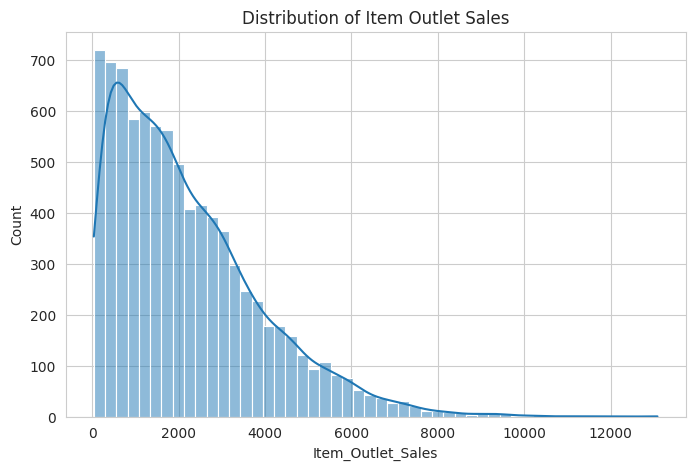

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(train['Item_Outlet_Sales'], bins=50, kde=True)
plt.title("Distribution of Item Outlet Sales")
plt.show()


3.4 Numerical Feature Distribution

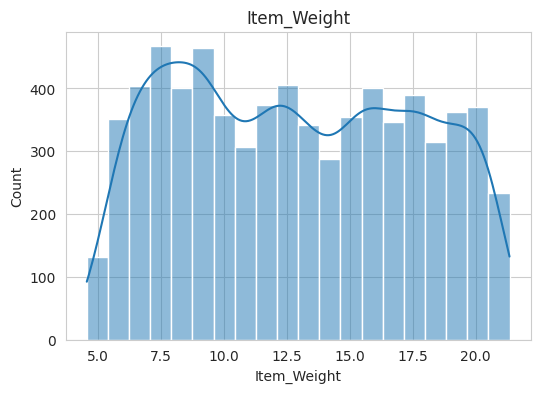

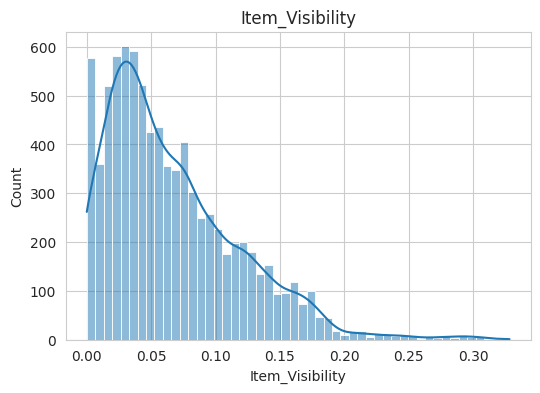

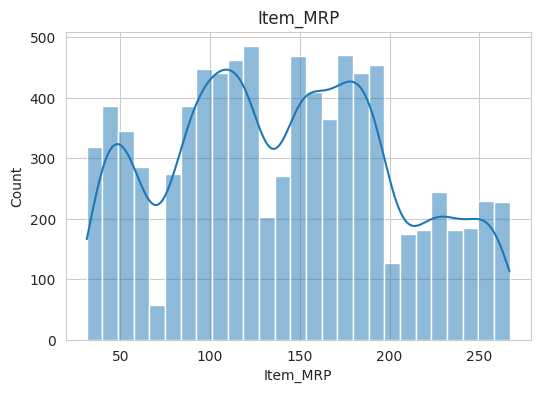

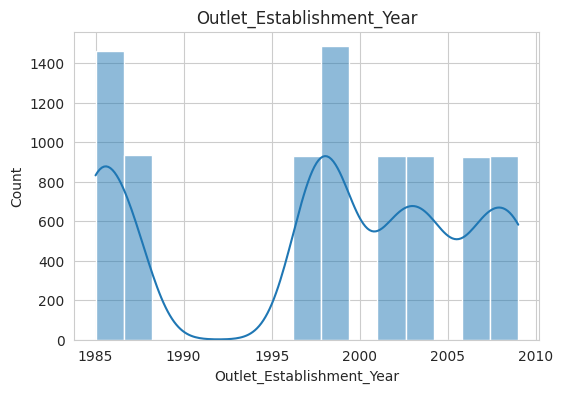

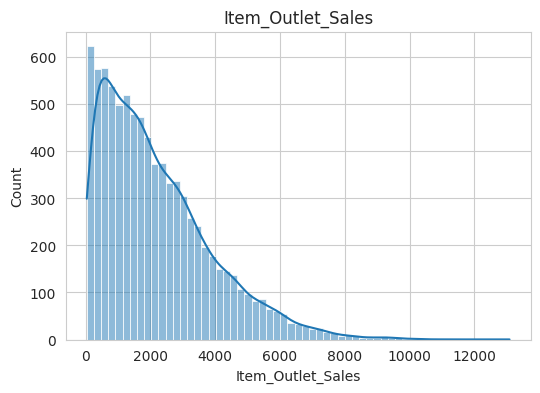

In [6]:
num_cols = train.select_dtypes(include=['int64','float64']).columns

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(train[col], kde=True)
    plt.title(col)
    plt.show()


3.5 Categorical vs Sales

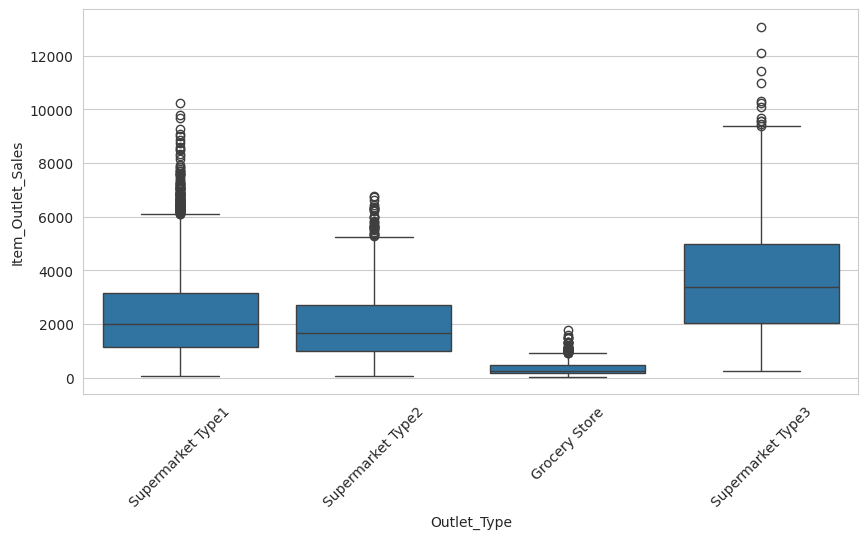

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Outlet_Type', y='Item_Outlet_Sales', data=train)
plt.xticks(rotation=45)
plt.show()


3.6 Correlation Heatmap

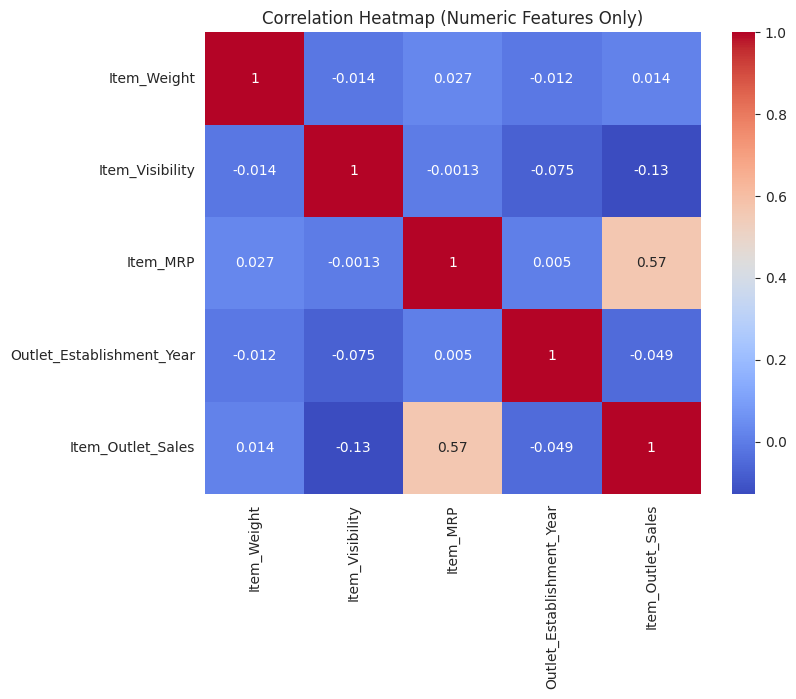

In [9]:
# Select only numeric columns
numeric_train = train.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(8,6))
sns.heatmap(numeric_train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


4. Data Cleaning + Feature Engineering

Combine Train & Test

In [10]:
train['source'] = 'train'
test['source'] = 'test'

data = pd.concat([train, test], ignore_index=True)


Fix Item_Fat_Content

In [11]:
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF':'Low Fat',
    'low fat':'Low Fat',
    'reg':'Regular'
})


Fill Missing Item_Weight

In [12]:
data['Item_Weight'] = data.groupby('Item_Identifier')['Item_Weight'].transform(
    lambda x: x.fillna(x.mean())
)


Fill Missing Outlet_Size

In [13]:
data['Outlet_Size'] = data.groupby('Outlet_Type')['Outlet_Size'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Medium")
)


Replace Zero Visibility

In [14]:
data['Item_Visibility'] = data.groupby('Item_Identifier')['Item_Visibility'].transform(
    lambda x: x.replace(0, x.mean())
)


Feature: Item_Type_Combined

In [15]:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[:2])

data['Item_Type_Combined'] = data['Item_Type_Combined'].map({
    'FD':'Food',
    'NC':'Non-Consumable',
    'DR':'Drinks'
})


Feature: Outlet_Age

In [16]:
data['Outlet_Age'] = 2013 - data['Outlet_Establishment_Year']

Mark Non-Consumables

In [17]:
data.loc[data['Item_Type_Combined']=="Non-Consumable",
         'Item_Fat_Content']="Non-Edible"


5. Encode Categorical Variables

In [18]:
cat_cols = data.select_dtypes(include='object').columns

le = LabelEncoder()

for col in cat_cols:
    data[col] = le.fit_transform(data[col])


6. Split Back Train & Test

In [19]:
train = data[data['source'] == 1]
test = data[data['source'] == 0]

train.drop(['source'], axis=1, inplace=True)
test.drop(['source', 'Item_Outlet_Sales'], axis=1, inplace=True)


7. Model Training

Prepare Data

In [20]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

X_test = test.copy()


Train/Test Split

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Train XGBoost

In [22]:
model = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

val_pred = model.predict(X_val)

print("Validation RMSE:",
      np.sqrt(mean_squared_error(y_val, val_pred)))

print("Validation R2:",
      r2_score(y_val, val_pred))


Validation RMSE: 1158.7000892000417
Validation R2: 0.5060335972046189


8. Feature Importance

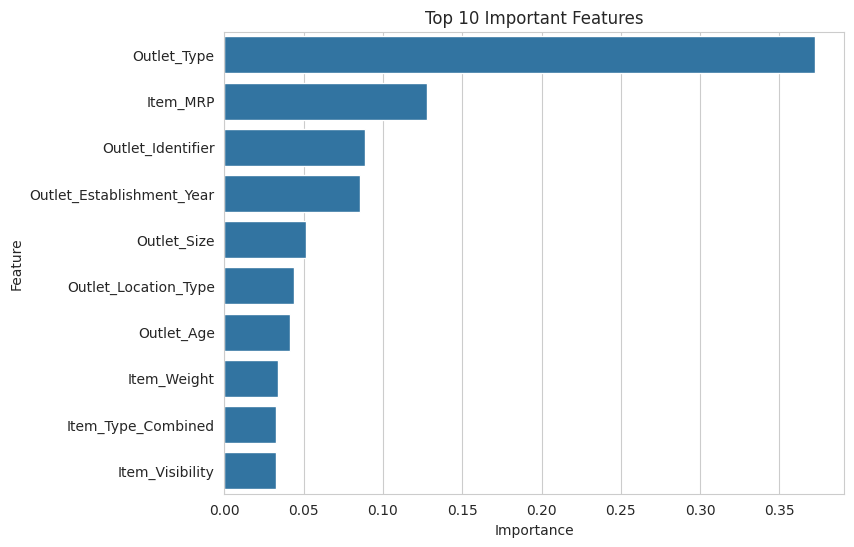

In [23]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title("Top 10 Important Features")
plt.show()


9. Train Final Model & Generate Submission

In [25]:
final_model = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X, y)

final_predictions = final_model.predict(X_test)

submission = sample_submission.copy()
submission['Item_Outlet_Sales'] = final_predictions

submission.to_csv("/content/BigMart_Final_Submission.csv", index=False)

print("Submission File Created!")


Submission File Created!


In [26]:
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val, val_pred)))
print("Validation R2:", r2_score(y_val, val_pred))


Validation RMSE: 1158.7000892000417
Validation R2: 0.5060335972046189
